<a href="https://colab.research.google.com/github/Peksyaji/Saham_PakPP/blob/main/Karakteristik_Saham_Prajogo_Pangestu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing dan PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Evaluasi
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import cophenet

# Visualisasi
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Semua library berhasil diimport!")

✅ Semua library berhasil diimport!


In [2]:
# Load data
df = pd.read_csv('/content/Daftar Variabel Clustering Saham.csv')

# Informasi dasar data
print("📊 Informasi Dataset:")
print(f"Shape: {df.shape}")
print(f"Emiten: {df['Emiten'].tolist()}")

📊 Informasi Dataset:
Shape: (6, 73)
Emiten: ['BRPT', 'TPIA', 'CUAN', 'BREN', 'PTRO', 'GZCO']


In [3]:
# Set emiten sebagai index
df_analysis = df.set_index('Emiten')

In [4]:
# Cek missing values
missing_info = df_analysis.isnull().sum()
missing_percent = (missing_info / len(df_analysis)) * 100

print("🔍 Missing Values:")
missing_summary = pd.DataFrame({
    'Missing Count': missing_info,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_summary[missing_summary['Missing Count'] > 0])

🔍 Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []


In [5]:
# Basic statistics
print(f"\n📈 Statistik Dasar:")
print(df_analysis.describe().round(2))


📈 Statistik Dasar:
       Current PE Ratio (TTM)  Earnings Yield (TTM)  \
count                    6.00                  6.00   
mean                   140.13                  4.41   
std                    178.10                  5.38   
min                      7.43                  0.21   
25%                     28.22                  0.66   
50%                     57.70                  1.94   
75%                    190.26                  7.01   
max                    465.12                 13.46   

       Current Price to Sales (TTM)  Current Price to Book Value  \
count                          6.00                         6.00   
mean                          21.74                        26.97   
std                           38.30                        39.33   
min                            0.75                         0.54   
25%                            3.25                         4.56   
50%                            7.37                        10.66   
75%     

In [6]:
# Hapus kolom dengan variance sangat rendah
variance_threshold = 1e-5
low_variance_cols = df_analysis.columns[df_analysis.var() < variance_threshold]
print(f"Kolom dengan variance rendah: {len(low_variance_cols)}")
if len(low_variance_cols) > 0:
    print(f"Kolom yang dihapus: {low_variance_cols.tolist()}")
    df_analysis = df_analysis.drop(columns=low_variance_cols)

print(f"Shape setelah cleaning: {df_analysis.shape}")

Kolom dengan variance rendah: 0
Shape setelah cleaning: (6, 72)


In [7]:
# Normalisasi data menggunakan StandardScaler (Z-score normalization)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(df_analysis)

# Convert back to DataFrame
df_normalized = pd.DataFrame(data_normalized,
                           index=df_analysis.index,
                           columns=df_analysis.columns)

print("\n✅ Normalisasi selesai!")
print("📊 Statistik data yang sudah dinormalisasi:")
print(f"Mean: {df_normalized.mean().round(2).head()}")
print(f"Std: {df_normalized.std().round(2).head()}")


✅ Normalisasi selesai!
📊 Statistik data yang sudah dinormalisasi:
Mean: Current PE Ratio (TTM)             0.0
Earnings Yield (TTM)              -0.0
Current Price to Sales (TTM)       0.0
Current Price to Book Value        0.0
Current Price To Cashflow (TTM)    0.0
dtype: float64
Std: Current PE Ratio (TTM)             1.1
Earnings Yield (TTM)               1.1
Current Price to Sales (TTM)       1.1
Current Price to Book Value        1.1
Current Price To Cashflow (TTM)    1.1
dtype: float64


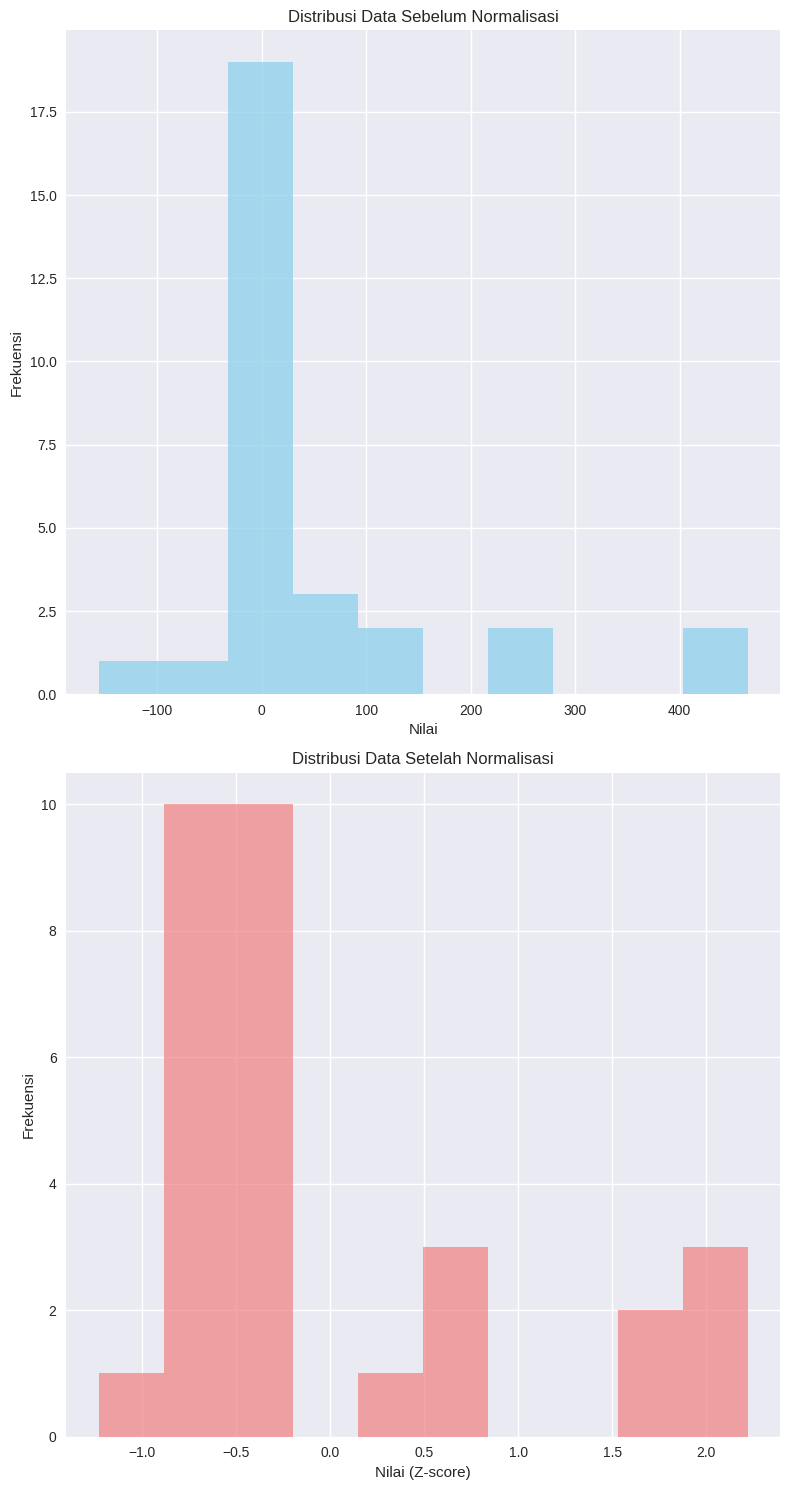

In [8]:
# Visualisasi perbandingan before/after normalization
fig, axes = plt.subplots(2, 1, figsize=(8, 15))

# Before normalization
axes[0].hist(df_analysis.iloc[:, :5].values.flatten(), alpha=0.7, color='skyblue')
axes[0].set_title('Distribusi Data Sebelum Normalisasi')
axes[0].set_xlabel('Nilai')
axes[0].set_ylabel('Frekuensi')

# After normalization
axes[1].hist(df_normalized.iloc[:, :5].values.flatten(), alpha=0.7, color='lightcoral')
axes[1].set_title('Distribusi Data Setelah Normalisasi')
axes[1].set_xlabel('Nilai (Z-score)')
axes[1].set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()

In [9]:
# Melakukan PCA
print("🔍 Melakukan Principal Component Analysis (PCA)...")

# Fit PCA dengan semua komponen
pca_full = PCA()
pca_full.fit(df_normalized)

# Hitung explained variance ratio
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Tentukan jumlah komponen untuk 80% dan 95% variance
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.80) + 1
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print(f"📈 Hasil PCA:")
print(f"Total fitur asli: {len(df_normalized.columns)}")
print(f"Komponen untuk 80% variance: {n_components_80}")
print(f"Komponen untuk 95% variance: {n_components_95}")
print(f"Variance explained PC1: {explained_variance_ratio[0]:.2f}")
print(f"Variance explained PC2: {explained_variance_ratio[1]:.2f}")

🔍 Melakukan Principal Component Analysis (PCA)...
📈 Hasil PCA:
Total fitur asli: 72
Komponen untuk 80% variance: 3
Komponen untuk 95% variance: 5
Variance explained PC1: 0.37
Variance explained PC2: 0.27


In [10]:
# PCA dengan jumlah komponen optimal (80% variance)
pca = PCA(n_components=n_components_80)
pca_components = pca.fit_transform(df_normalized)

# Create DataFrame untuk PCA components
pca_df = pd.DataFrame(pca_components,
                     index=df_normalized.index,
                     columns=[f'PC{i+1}' for i in range(n_components_80)])

print(f"✅ PCA selesai dengan {n_components_80} komponen!")
print(f"Total variance explained: {cumulative_variance_ratio[n_components_80-1]:.3f}")

✅ PCA selesai dengan 3 komponen!
Total variance explained: 0.809


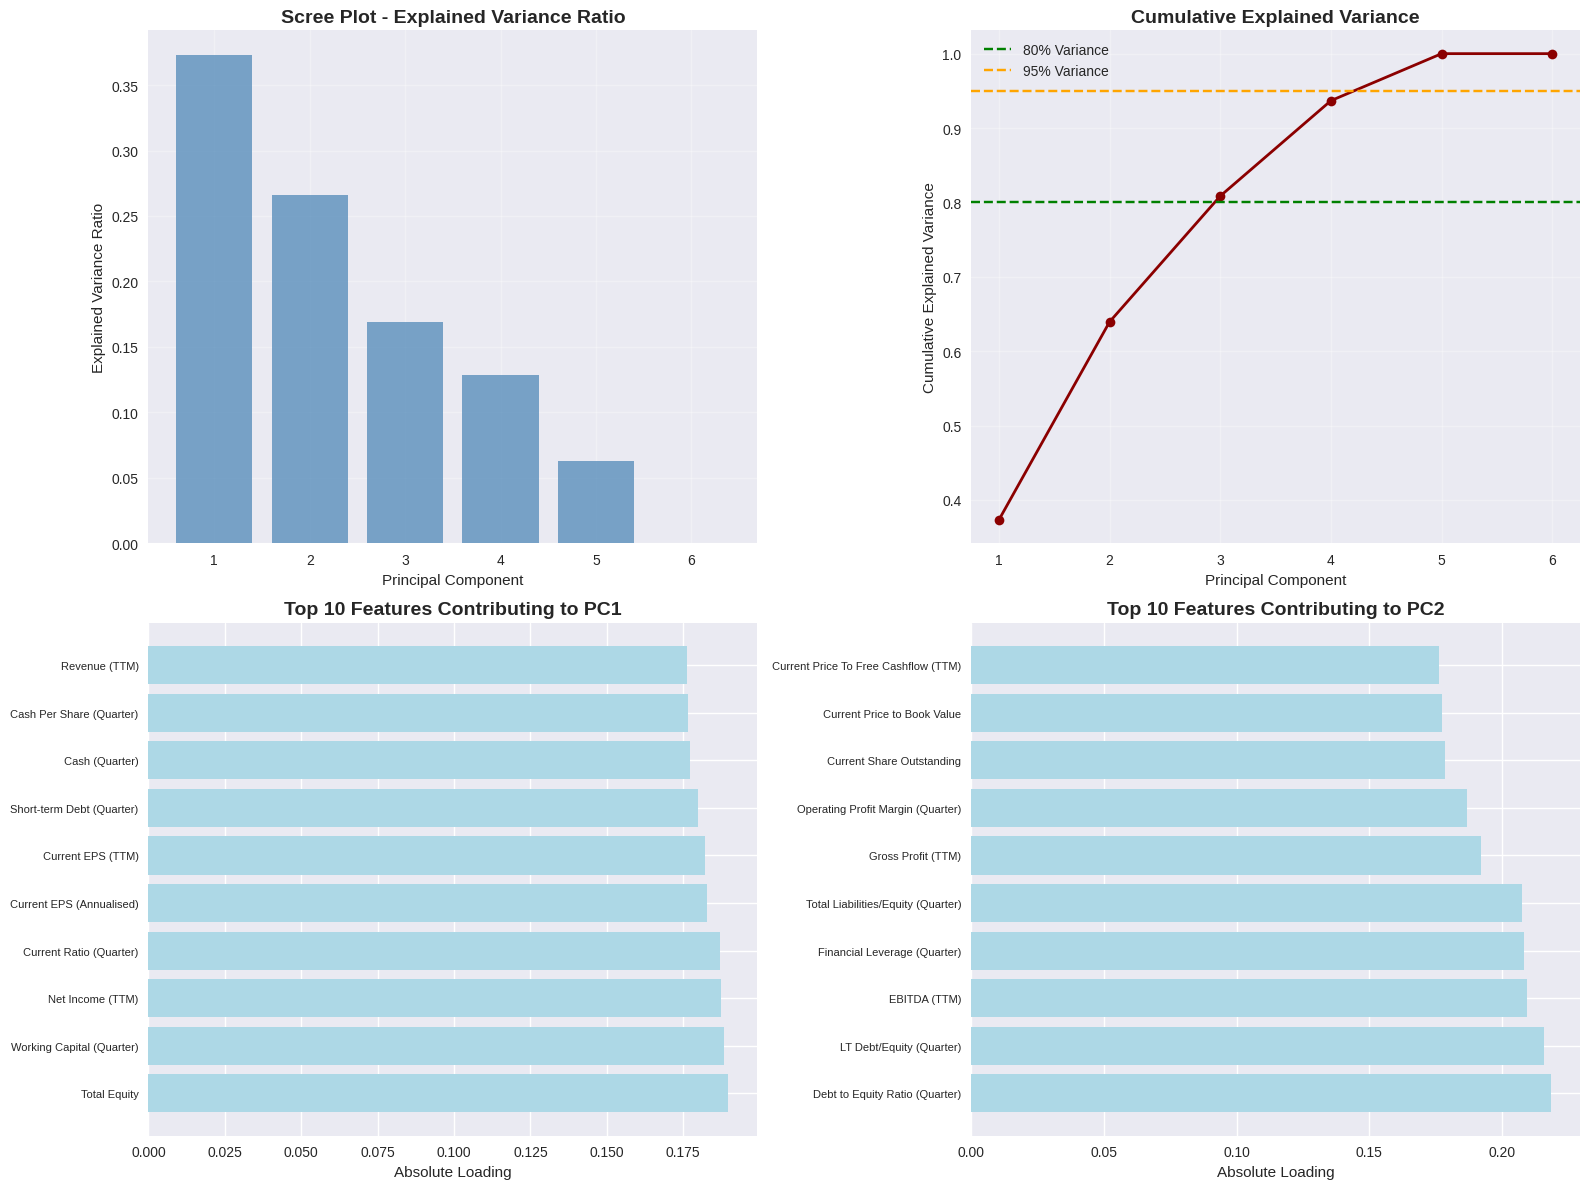

In [11]:
# ## 3. Visualisasi Hasil PCA

# 1. Scree Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scree Plot - Explained Variance
axes[0,0].bar(range(1, min(21, len(explained_variance_ratio)+1)),
              explained_variance_ratio[:20], alpha=0.7, color='steelblue')
axes[0,0].set_title('Scree Plot - Explained Variance Ratio', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Explained Variance Ratio')
axes[0,0].grid(True, alpha=0.3)

# Cumulative Explained Variance
axes[0,1].plot(range(1, min(21, len(cumulative_variance_ratio)+1)),
               cumulative_variance_ratio[:20], 'o-', color='darkred', linewidth=2)
axes[0,1].axhline(y=0.8, color='green', linestyle='--', label='80% Variance')
axes[0,1].axhline(y=0.95, color='orange', linestyle='--', label='95% Variance')
axes[0,1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Principal Component')
axes[0,1].set_ylabel('Cumulative Explained Variance')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 2. Feature Contribution to PC1 and PC2
feature_importance = pd.DataFrame({
    'Feature': df_normalized.columns,
    'PC1': abs(pca.components_[0]),
    'PC2': abs(pca.components_[1])
})

# Top contributing features to PC1
top_pc1 = feature_importance.nlargest(10, 'PC1')['Feature'].tolist()
top_pc1_values = feature_importance.nlargest(10, 'PC1')['PC1'].tolist()

axes[1,0].barh(range(len(top_pc1)), top_pc1_values, color='lightblue')
axes[1,0].set_yticks(range(len(top_pc1)))
axes[1,0].set_yticklabels([f.replace('.', '\n') for f in top_pc1], fontsize=8)
axes[1,0].set_title('Top 10 Features Contributing to PC1', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Absolute Loading')

# Top contributing features to PC2
top_pc2 = feature_importance.nlargest(10, 'PC2')['Feature'].tolist()
top_pc2_values = feature_importance.nlargest(10, 'PC2')['PC2'].tolist()

axes[1,1].barh(range(len(top_pc2)), top_pc2_values, color='lightblue')
axes[1,1].set_yticks(range(len(top_pc2)))
axes[1,1].set_yticklabels([f.replace('.', '\n') for f in top_pc2], fontsize=8)
axes[1,1].set_title('Top 10 Features Contributing to PC2', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Absolute Loading')

plt.tight_layout()
plt.show()

In [12]:
# Hitung Sum of Squared Loadings untuk setiap variabel
# Sum of Squared Loadings (SSL) = sum of squares of loadings across selected components
# Loadings are the coefficients of the principal components
loadings = pca.components_[:n_components_80].T # Ambil loadings dari komponen yang dipilih (80% variance)

ssl = np.sum(loadings**2, axis=1)

# Buat DataFrame untuk hasil SSL
ssl_df = pd.DataFrame({
    'Feature': df_normalized.columns,
    'Sum_of_Squared_Loadings': ssl
})

# Urutkan berdasarkan SSL dan tampilkan top 10
ranked_variables = ssl_df.sort_values('Sum_of_Squared_Loadings', ascending=False)

print("🔝 10 Variabel Paling Berpengaruh (berdasarkan Sum of Squared Loadings):")
display(ranked_variables.head(10))


🔝 10 Variabel Paling Berpengaruh (berdasarkan Sum of Squared Loadings):


,Feature,Sum_of_Squared_Loadings
21,Free cash flow (Quarter),0.075449
45,Relative Strength Rating,0.067767
70,Price Performance 3M,0.067002
3,Current Price to Book Value,0.062377
71,Price Performance 6M,0.061846
68,Free cash flow (TTM),0.061361
30,Market Cap,0.061211
31,Enterprise Value,0.061181
2,Current Price to Sales (TTM),0.060179
51,Rank (Near 52 Weeks High),0.055029


In [26]:
top_features = ranked_variables.iloc[10]

In [16]:
# 4. Biplot interaktif dengan Plotly
fig_biplot = go.Figure()

# Add scatter plot untuk emiten
fig_biplot.add_trace(go.Scatter(
    x=pca_df['PC1'],
    y=pca_df['PC2'],
    mode='markers+text',
    text=pca_df.index,
    textposition='top center',
    marker=dict(size=12, color='blue', opacity=0.7),
    name='Emiten'
))

# Use feature_loadings for biplot vectors
feature_loadings = pd.DataFrame({
    'feature': df_normalized.columns,
    'pc1': pca.components_[0] * 3,  # Scale for visibility
    'pc2': pca.components_[1] * 3,
    'pc3': pca.components_[2] * 3
})

top_features_biplot = feature_loadings.nlargest(10, 'pc1') # Select top features based on PC1 loading for biplot

for index, row in top_features_biplot.iterrows():
    fig_biplot.add_trace(go.Scatter(
        x=[0, row['pc1']], y=[0, row['pc2']],
        mode='lines+text',
        text=['', row['feature']],
        textposition='top center',
        line=dict(color='red', width=1),
        showlegend=False,
        opacity=0.6
    ))


fig_biplot.update_layout(
    title='PCA Biplot - Emiten dan Top Features',
    xaxis_title=f'PC1 ({explained_variance_ratio[0]:.2%} variance)',
    yaxis_title=f'PC2 ({explained_variance_ratio[1]:.2%} variance)',
    width=800, height=600
)

fig_biplot.show()

In [17]:
# Hierarchical Clustering menggunakan data PCA
print("🔗 Melakukan Hierarchical Clustering...")

# Gunakan data PCA untuk clustering
X_clustering = pca_components

# Berbagai metode linkage
linkage_methods = ['ward', 'complete', 'average', 'single']
linkage_results = {}

for method in linkage_methods:
    # Compute linkage matrix
    if method == 'ward':
        # Ward membutuhkan euclidean distance
        Z = linkage(X_clustering, method=method, metric='euclidean')
    else:
        Z = linkage(X_clustering, method=method, metric='euclidean')

    linkage_results[method] = Z

    # Compute cophenetic correlation
    c, coph_dists = cophenet(Z, pdist(X_clustering))
    print(f"Cophenetic correlation ({method}): {c:.4f}")

🔗 Melakukan Hierarchical Clustering...
Cophenetic correlation (ward): 0.7402
Cophenetic correlation (complete): 0.7258
Cophenetic correlation (average): 0.8078
Cophenetic correlation (single): 0.7623


In [18]:
# Pilih metode terbaik
best_method = 'average'
Z_best = linkage_results[best_method]

print(f"✅ Menggunakan metode linkage: {best_method}")

✅ Menggunakan metode linkage: average


In [19]:
# ## 5. Evaluasi Clustering

# Evaluasi untuk menentukan jumlah cluster optimal
print("📊 Evaluasi untuk menentukan jumlah cluster optimal...")

k_range = range(2, min(8, len(df_normalized)))
silhouette_scores = []
inertias = []

# Hitung silhouette score untuk berbagai k
for k in k_range:
    # Get cluster labels
    cluster_labels = fcluster(Z_best, k, criterion='maxclust')

    # Compute silhouette score
    sil_score = silhouette_score(X_clustering, cluster_labels)
    silhouette_scores.append(sil_score)

    # Compute inertia (within-cluster sum of squares)
    clusters_unique = np.unique(cluster_labels)
    inertia = 0
    for cluster in clusters_unique:
        cluster_points = X_clustering[cluster_labels == cluster]
        if len(cluster_points) > 1:
            centroid = np.mean(cluster_points, axis=0)
            inertia += np.sum((cluster_points - centroid) ** 2)
    inertias.append(inertia)

print(f"Silhouette scores: {[f'{s:.3f}' for s in silhouette_scores]}")

📊 Evaluasi untuk menentukan jumlah cluster optimal...
Silhouette scores: ['0.254', '0.166', '0.181', '0.148']


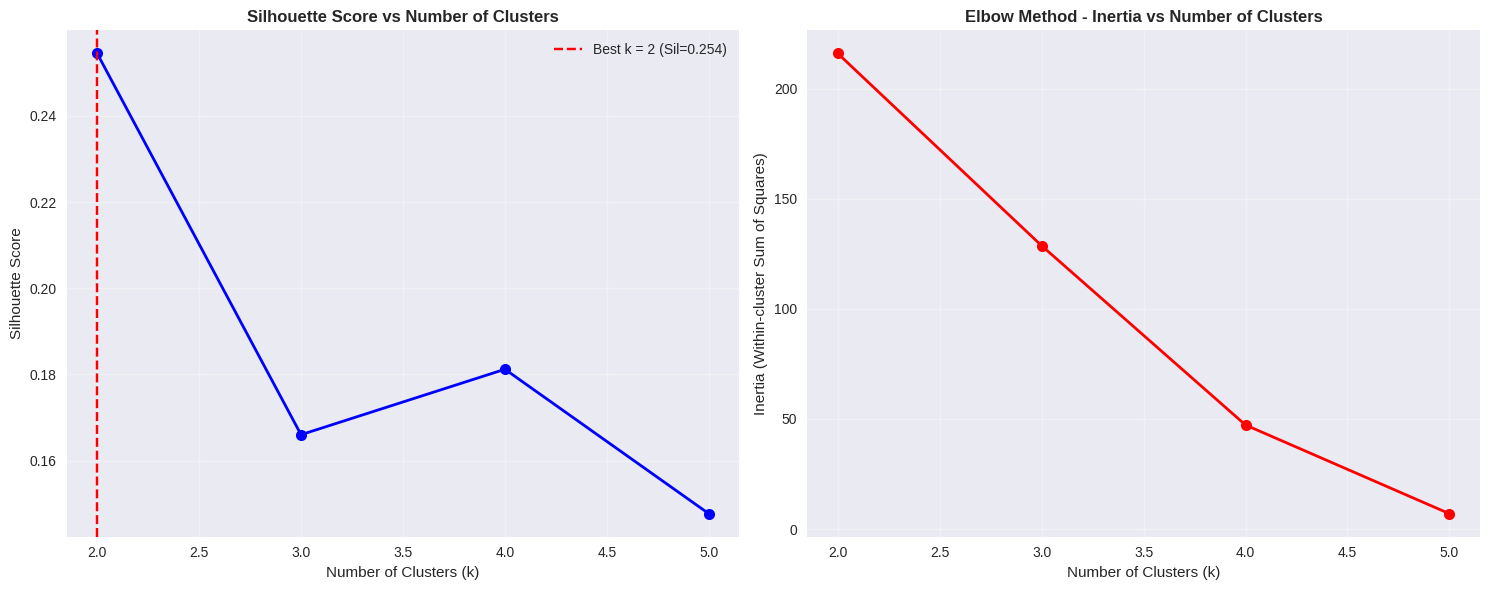

In [20]:
# Plot evaluasi metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Silhouette Score
axes[0].plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Silhouette Score vs Number of Clusters', fontweight='bold')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].grid(True, alpha=0.3)
best_k_sil = k_range[np.argmax(silhouette_scores)]
axes[0].axvline(x=best_k_sil, color='red', linestyle='--',
                label=f'Best k = {best_k_sil} (Sil={max(silhouette_scores):.3f})')
axes[0].legend()

# Elbow Method (Inertia)
axes[1].plot(k_range, inertias, 'ro-', linewidth=2, markersize=8)
axes[1].set_title('Elbow Method - Inertia vs Number of Clusters', fontweight='bold')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Inertia (Within-cluster Sum of Squares)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Tentukan k optimal
k_optimal = best_k_sil
print(f"🎯 Jumlah cluster optimal: {k_optimal}")
print(f"Silhouette Score: {max(silhouette_scores):.3f}")

🎯 Jumlah cluster optimal: 2
Silhouette Score: 0.254


In [22]:
# Generate final clusters
final_clusters = fcluster(Z_best, k_optimal, criterion='maxclust')

📈 Visualisasi hasil clustering...


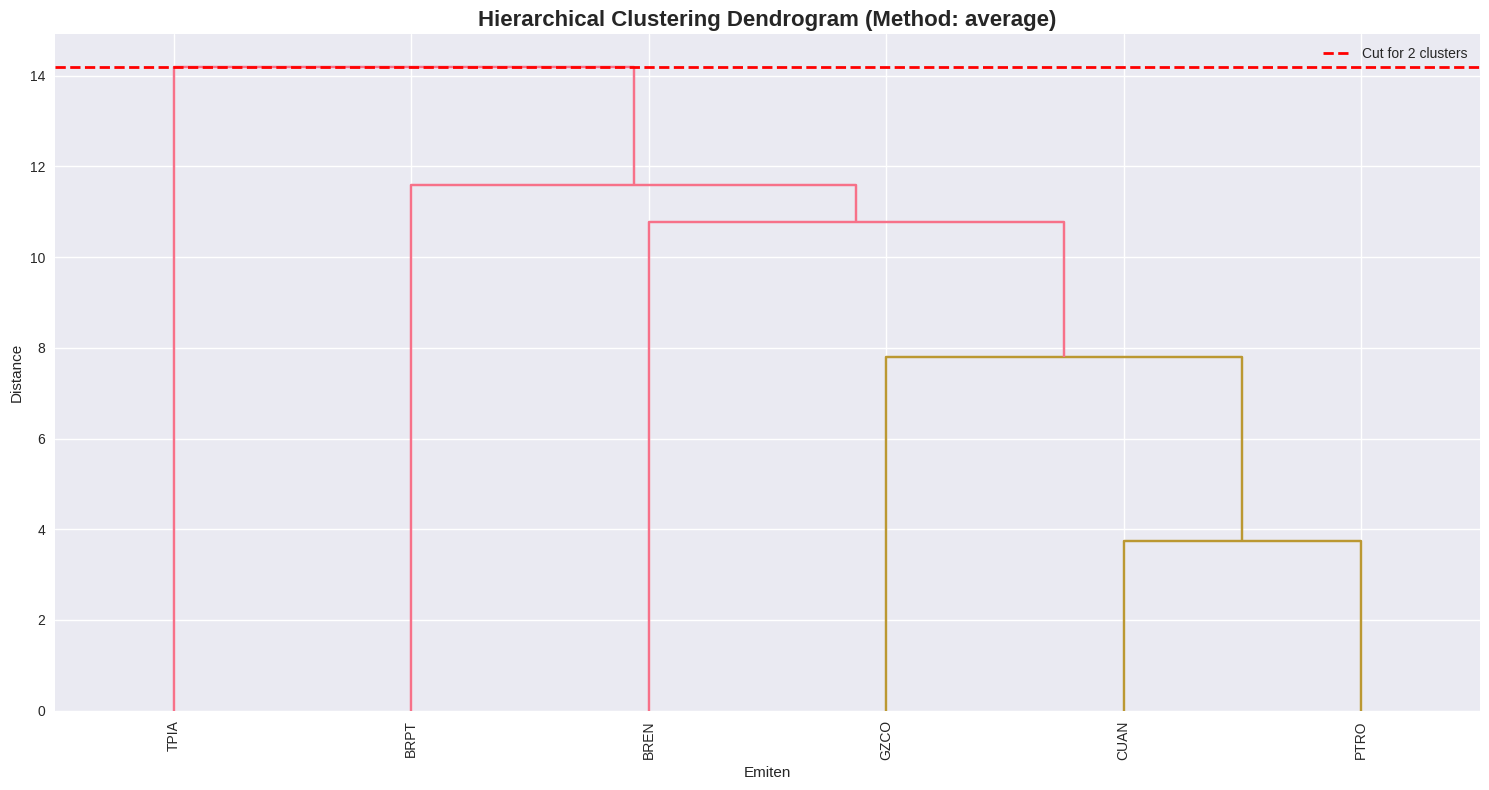

In [23]:
# ## 6. Visualisasi Hasil Clustering

# Visualisasi hasil clustering
print("📈 Visualisasi hasil clustering...")

# 1. Dendrogram
plt.figure(figsize=(15, 8))
dendrogram(Z_best, labels=df_normalized.index, orientation='top',
           leaf_rotation=90, leaf_font_size=10)
plt.title(f'Hierarchical Clustering Dendrogram (Method: {best_method})',
          fontsize=16, fontweight='bold')
plt.xlabel('Emiten')
plt.ylabel('Distance')

# Tambahkan garis horizontal untuk menunjukkan cut
max_d = Z_best[-k_optimal+1, 2]  # Distance pada k cluster
plt.axhline(y=max_d, color='red', linestyle='--', linewidth=2,
            label=f'Cut for {k_optimal} clusters')
plt.legend()
plt.tight_layout()
plt.show()

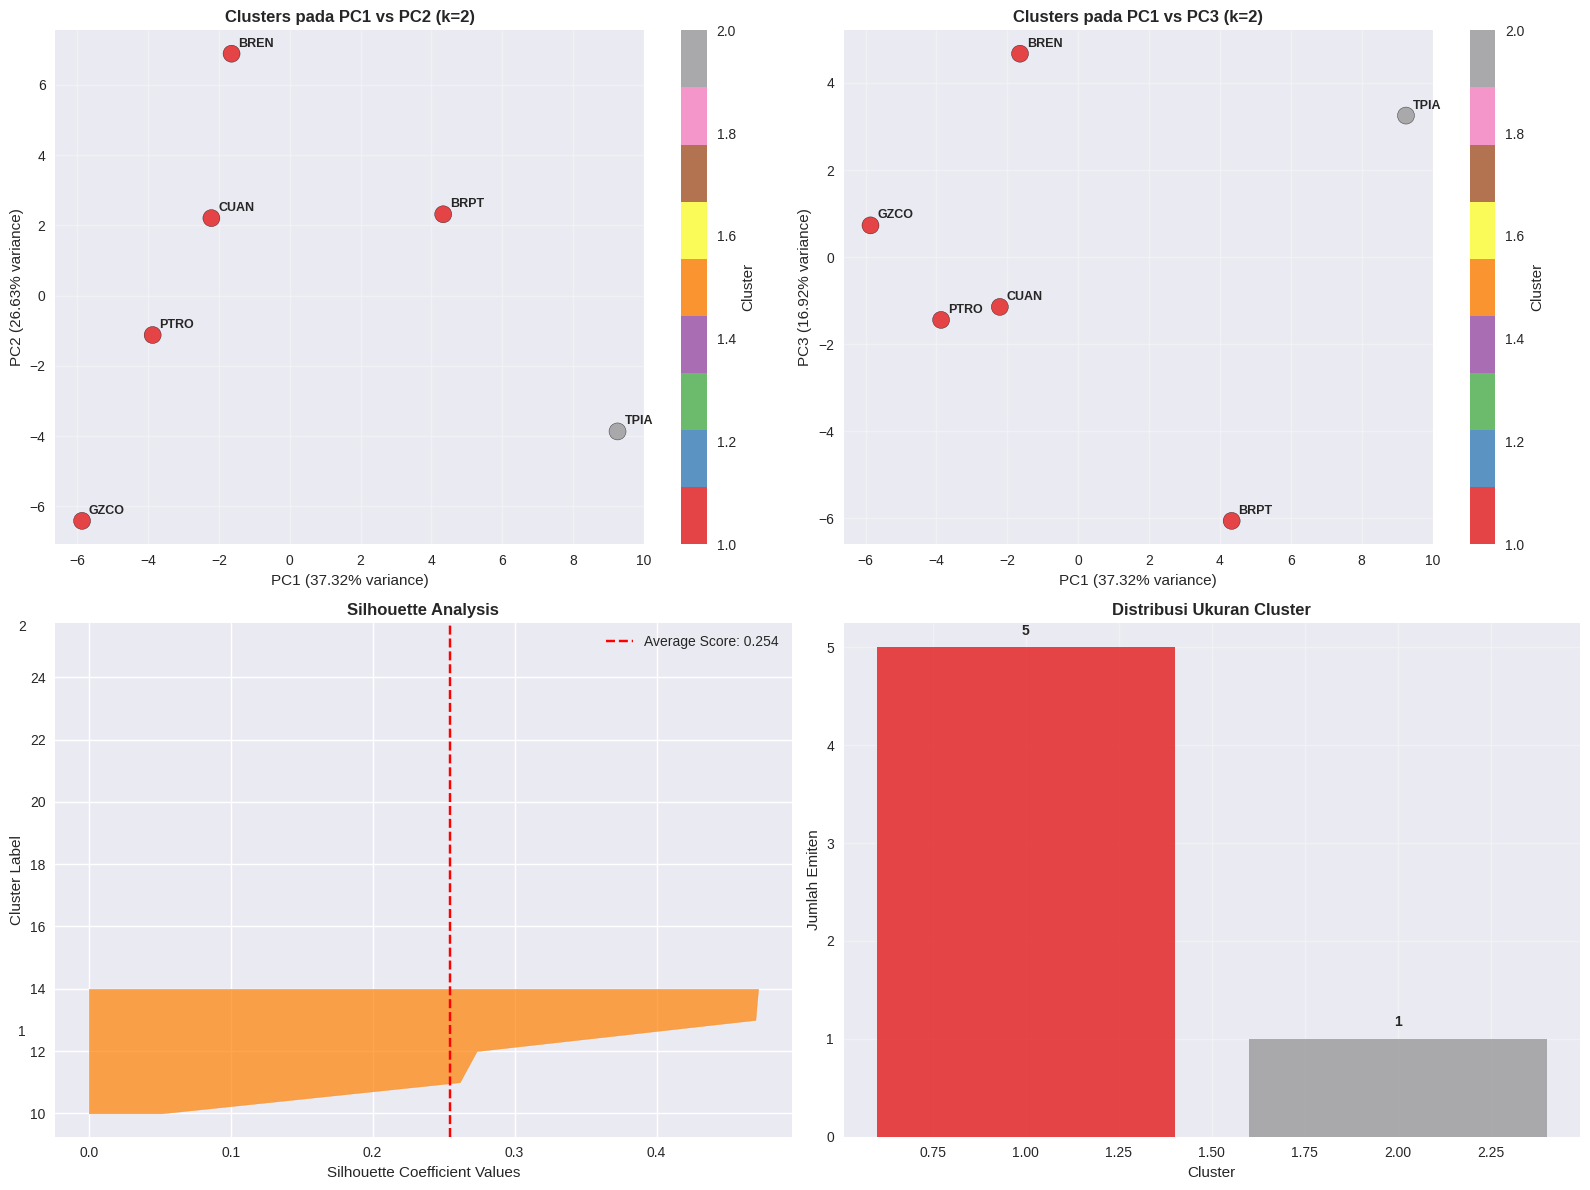

In [24]:
# 2. Cluster visualization pada PCA space
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PC1 vs PC2 dengan cluster colors
scatter = axes[0,0].scatter(pca_df['PC1'], pca_df['PC2'],
                           c=final_clusters, cmap='Set1',
                           alpha=0.8, s=150, edgecolors='black')
axes[0,0].set_title(f'Clusters pada PC1 vs PC2 (k={k_optimal})', fontweight='bold')
axes[0,0].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} variance)')
axes[0,0].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} variance)')
axes[0,0].grid(True, alpha=0.3)

# Tambahkan label emiten
for i, emiten in enumerate(pca_df.index):
    axes[0,0].annotate(emiten, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]),
                      xytext=(5, 5), textcoords='offset points',
                      fontsize=9, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[0,0])
cbar.set_label('Cluster')

# 3. PC1 vs PC3
if pca_df.shape[1] > 2:
    scatter2 = axes[0,1].scatter(pca_df['PC1'], pca_df['PC3'],
                               c=final_clusters, cmap='Set1',
                               alpha=0.8, s=150, edgecolors='black')
    axes[0,1].set_title(f'Clusters pada PC1 vs PC3 (k={k_optimal})', fontweight='bold')
    axes[0,1].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} variance)')
    axes[0,1].set_ylabel(f'PC3 ({explained_variance_ratio[2]:.2%} variance)')
    axes[0,1].grid(True, alpha=0.3)

# Tambahkan label emiten
for i, emiten in enumerate(pca_df.index):
    axes[0,1].annotate(emiten, (pca_df.iloc[i, 0], pca_df.iloc[i, 2]),
                      xytext=(5, 5), textcoords='offset points',
                      fontsize=9, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[0,1])
cbar.set_label('Cluster')

# 4. Silhouette Analysis
sil_samples = silhouette_samples(X_clustering, final_clusters)
y_lower = 10

for i in range(1, k_optimal + 1):
    ith_cluster_silhouette_values = sil_samples[final_clusters == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.Set1(i / k_optimal)
    axes[1,0].fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)

    axes[1,0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1,0].set_title('Silhouette Analysis', fontweight='bold')
axes[1,0].set_xlabel('Silhouette Coefficient Values')
axes[1,0].set_ylabel('Cluster Label')

# Tambahkan garis rata-rata silhouette score
axes[1,0].axvline(x=silhouette_score(X_clustering, final_clusters),
                 color="red", linestyle="--",
                 label=f'Average Score: {silhouette_score(X_clustering, final_clusters):.3f}')
axes[1,0].legend()

# 5. Cluster size distribution
cluster_counts = pd.Series(final_clusters).value_counts().sort_index()
axes[1,1].bar(cluster_counts.index, cluster_counts.values,
             color=plt.cm.Set1(np.linspace(0, 1, k_optimal)), alpha=0.8)
axes[1,1].set_title('Distribusi Ukuran Cluster', fontweight='bold')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Jumlah Emiten')
axes[1,1].grid(True, alpha=0.3)

# Tambahkan nilai di atas bar
for i, v in enumerate(cluster_counts.values):
    axes[1,1].text(cluster_counts.index[i], v + 0.1, str(v),
                  ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [29]:
# ## 7. Analisis/Profiling Cluster

# Analisis dan profiling setiap cluster
print("🔍 Analisis dan Profiling Cluster")
print("="*50)

# Tambahkan informasi cluster ke data
df_analysis_with_clusters = df_normalized.copy()
df_analysis_with_clusters['Cluster'] = final_clusters

# Original data dengan cluster
df_original_with_clusters = df_analysis.copy()
df_original_with_clusters['Cluster'] = final_clusters

# 1. Summary setiap cluster
print(f"\n📊 Summary Cluster (Total: {k_optimal} clusters)")
cluster_summary = pd.DataFrame({
    'Cluster': range(1, k_optimal + 1),
    'Jumlah_Emiten': [sum(final_clusters == i) for i in range(1, k_optimal + 1)],
    'Persentase': [sum(final_clusters == i)/len(final_clusters)*100 for i in range(1, k_optimal + 1)]
})

print(cluster_summary.round(2))

# 2. Daftar emiten per cluster
print(f"\n📋 Daftar Emiten per Cluster:")
for i in range(1, k_optimal + 1):
    cluster_emiten = df_analysis_with_clusters[df_analysis_with_clusters['Cluster'] == i].index.tolist()
    print(f"\n🏢 Cluster {i}: {cluster_emiten}")

# 3. Profiling berdasarkan variabel kunci
# Pilih variabel kunci untuk profiling
key_variables = ranked_variables['Feature'].tolist() # Mengambil daftar fitur dari ranked_variables

# Filter variabel yang tersedia
available_key_vars = [var for var in key_variables if var in df_original_with_clusters.columns]
print(f"\n🔑 Variabel kunci yang tersedia: {len(available_key_vars)}")

if available_key_vars:
    # Buat profiling table
    cluster_profiles = []

    for i in range(1, k_optimal + 1):
        cluster_data = df_original_with_clusters[df_original_with_clusters['Cluster'] == i]

        profile = {
            'Cluster': i,
            'Jumlah_Emiten': len(cluster_data)
        }

        for var in available_key_vars:
            profile[f'{var}_mean'] = cluster_data[var].mean()
            profile[f'{var}_median'] = cluster_data[var].median()
            profile[f'{var}_std'] = cluster_data[var].std()

        cluster_profiles.append(profile)

    profile_df = pd.DataFrame(cluster_profiles)

    # Display profiling untuk setiap cluster
    print(f"\n📈 Profiling Cluster (Variabel Kunci):")
    print("="*80)

    for i in range(1, k_optimal + 1):
        print(f"\n🏆 CLUSTER {i} PROFILE:")
        print("-" * 40)

        cluster_data = df_original_with_clusters[df_original_with_clusters['Cluster'] == i]

        for var in available_key_vars[:10]:  # Top 10 variabel
            mean_val = cluster_data[var].mean()
            median_val = cluster_data[var].median()
            print(f"{var}:")
            print(f"  Mean: {mean_val:.2f}, Median: {median_val:.2f}")

        print()

🔍 Analisis dan Profiling Cluster

📊 Summary Cluster (Total: 2 clusters)
   Cluster  Jumlah_Emiten  Persentase
0        1              5       83.33
1        2              1       16.67

📋 Daftar Emiten per Cluster:

🏢 Cluster 1: ['BRPT', 'CUAN', 'BREN', 'PTRO', 'GZCO']

🏢 Cluster 2: ['TPIA']

🔑 Variabel kunci yang tersedia: 72

📈 Profiling Cluster (Variabel Kunci):

🏆 CLUSTER 1 PROFILE:
----------------------------------------
Free cash flow (Quarter):
  Mean: -2077.40, Median: -1529.00
Relative Strength Rating:
  Mean: 80.60, Median: 89.00
Price Performance 3M:
  Mean: 62.91, Median: 21.85
Current Price to Book Value:
  Mean: 29.88, Median: 8.91
Price Performance 6M:
  Mean: 50.16, Median: 19.44
Free cash flow (TTM):
  Mean: -3634.00, Median: -3852.00
Market Cap:
  Mean: 278508.80, Median: 164132.00
Enterprise Value:
  Mean: 293094.80, Median: 182807.00
Current Price to Sales (TTM):
  Mean: 23.56, Median: 4.05
Rank (Near 52 Weeks High):
  Mean: 54.80, Median: 63.00


🏆 CLUSTER 2 PROF

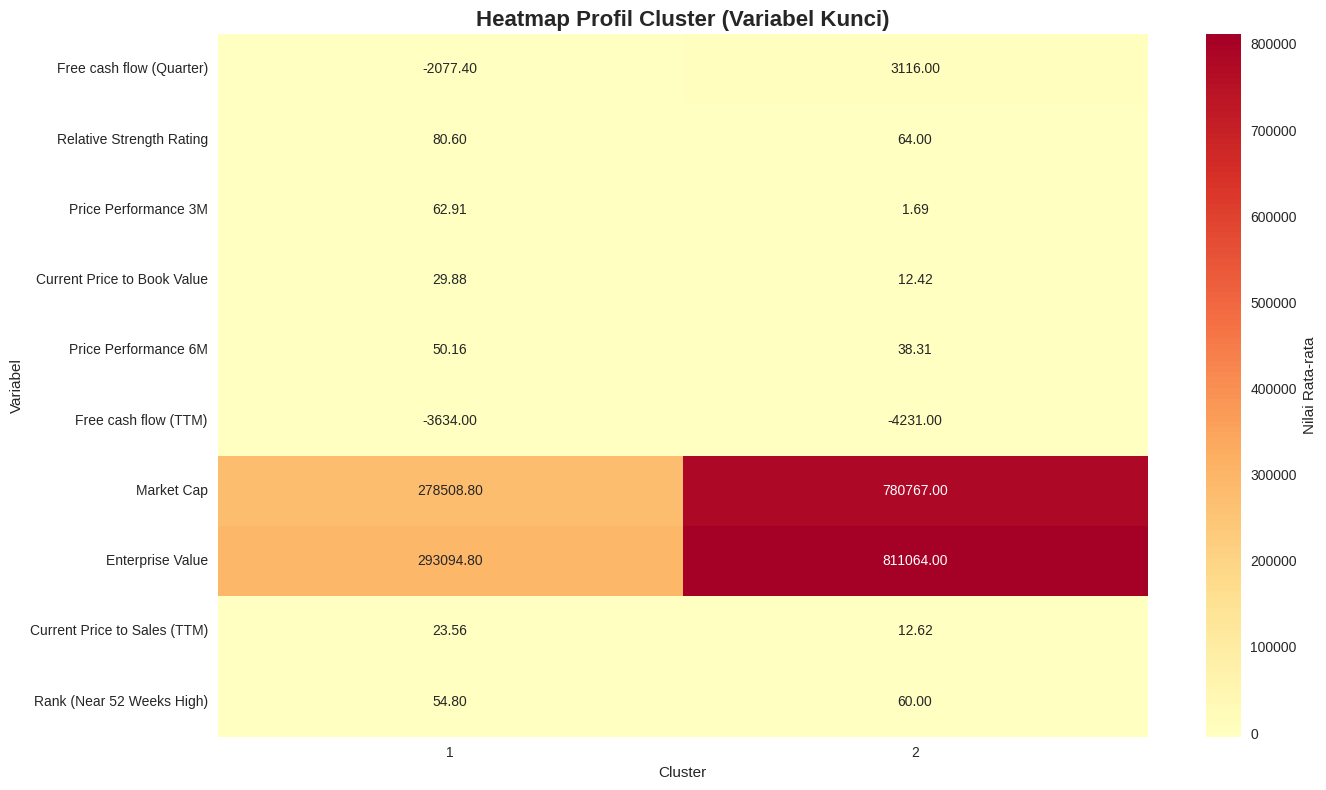

In [31]:
# 4. Heatmap perbandingan cluster
if available_key_vars:
    # Buat matrix untuk heatmap
    cluster_means = df_original_with_clusters.groupby('Cluster')[available_key_vars[:10]].mean()

    plt.figure(figsize=(14, 8))
    sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='RdYlBu_r',
                center=0, cbar_kws={'label': 'Nilai Rata-rata'})
    plt.title('Heatmap Profil Cluster (Variabel Kunci)', fontsize=16, fontweight='bold')
    plt.xlabel('Cluster')
    plt.ylabel('Variabel')
    plt.tight_layout()
    plt.show()

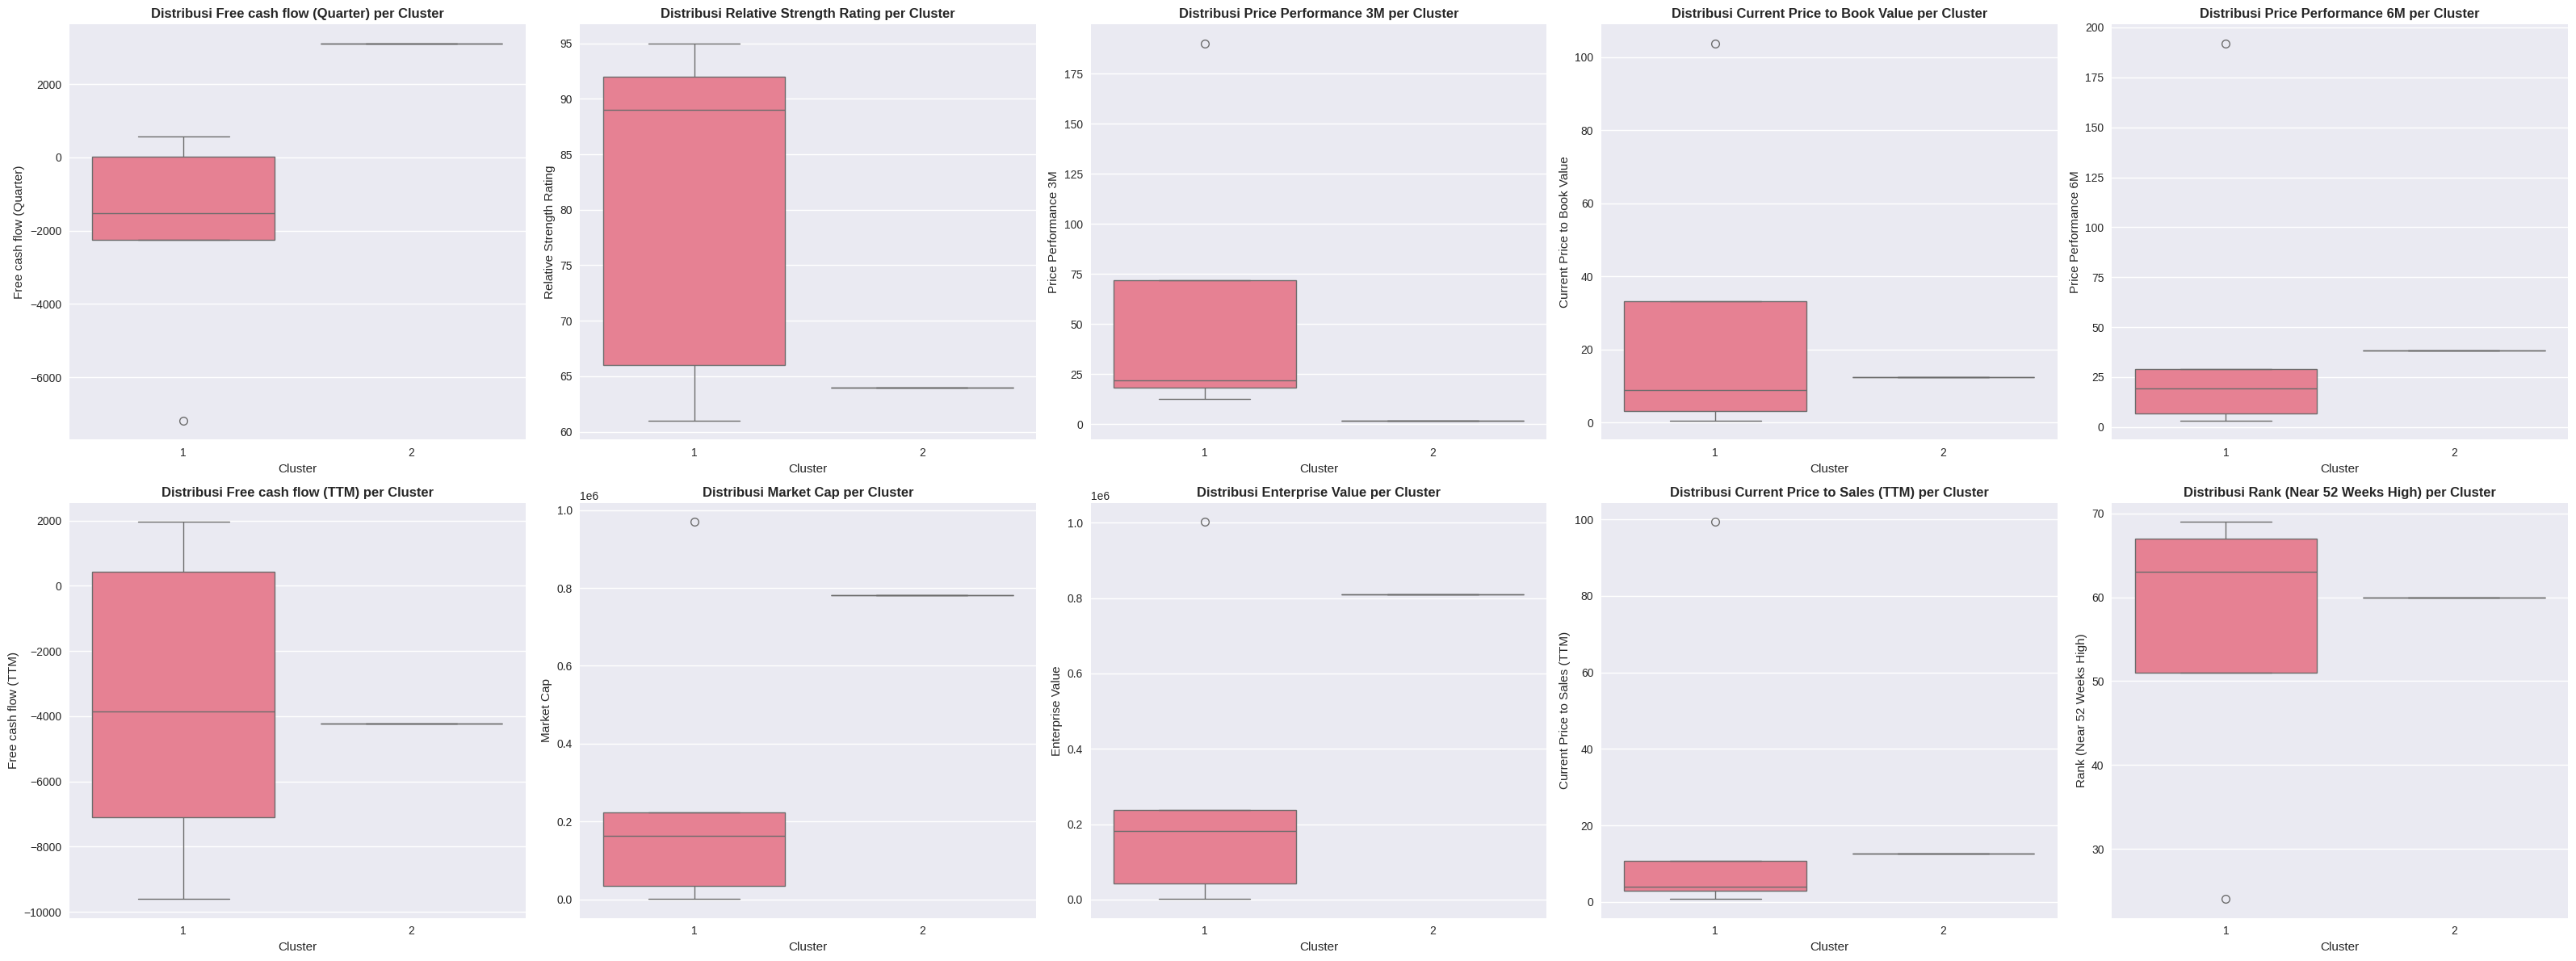

In [32]:
# 5. Box plots untuk variabel kunci
if available_key_vars and len(available_key_vars) >= 4:
    fig, axes = plt.subplots(2, 5, figsize=(32, 12))
    axes = axes.ravel()

    for i, var in enumerate(available_key_vars[:10]):
        sns.boxplot(data=df_original_with_clusters, x='Cluster', y=var, ax=axes[i])
        axes[i].set_title(f'Distribusi {var} per Cluster', fontweight='bold')
        axes[i].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

In [33]:
# 6. Radar Chart untuk perbandingan cluster
if available_key_vars and len(available_key_vars) >= 5:
    # Normalize data untuk radar chart
    radar_data = cluster_means.copy()
    radar_data_normalized = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

    # Buat radar chart
    fig = go.Figure()

    for i in range(1, k_optimal + 1):
        values = radar_data_normalized.loc[i, available_key_vars[:10]].tolist()
        values += [values[0]]  # Tutup lingkaran

        labels = available_key_vars[:10] + [available_key_vars[0]]

        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=labels,
            fill='toself',
            name=f'Cluster {i}'
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        title="Radar Chart - Perbandingan Profil Cluster",
        width=800, height=600
    )

    fig.show()

In [34]:
# 7. Summary dan Interpretasi
print(f"\n🎯 SUMMARY DAN INTERPRETASI:")
print("="*60)
print(f"✅ Jumlah cluster optimal: {k_optimal}")
print(f"✅ Silhouette Score: {silhouette_score(X_clustering, final_clusters):.3f}")
print(f"✅ Metode clustering: Hierarchical ({best_method})")
print(f"✅ Jumlah komponen PCA: {n_components_80}")
print(f"✅ Total variance explained: {cumulative_variance_ratio[n_components_80-1]:.2%}")


🎯 SUMMARY DAN INTERPRETASI:
✅ Jumlah cluster optimal: 2
✅ Silhouette Score: 0.254
✅ Metode clustering: Hierarchical (average)
✅ Jumlah komponen PCA: 3
✅ Total variance explained: 80.86%


In [35]:
# Interpretasi berdasarkan Silhouette Score
sil_score = silhouette_score(X_clustering, final_clusters)
if sil_score > 0.7:
    interpretation = "SANGAT BAIK - Cluster sangat terpisah dan well-defined"
elif sil_score > 0.5:
    interpretation = "BAIK - Cluster cukup terpisah dengan struktur yang jelas"
elif sil_score > 0.25:
    interpretation = "SEDANG - Cluster dapat diterima namun ada overlap"
else:
    interpretation = "LEMAH - Struktur cluster kurang jelas"

print(f"✅ Kualitas clustering: {interpretation}")

✅ Kualitas clustering: SEDANG - Cluster dapat diterima namun ada overlap


In [36]:
# Karakteristik setiap cluster
print(f"\n🏷️ KARAKTERISTIK SETIAP CLUSTER:")
print("-" * 50)

for i in range(1, k_optimal + 1):
    cluster_emiten = df_analysis_with_clusters[df_analysis_with_clusters['Cluster'] == i].index.tolist()
    print(f"\n📊 Cluster {i} ({len(cluster_emiten)} emiten): {', '.join(cluster_emiten)}")

    if available_key_vars:
        cluster_data = df_original_with_clusters[df_original_with_clusters['Cluster'] == i]

        # Cari karakteristik dominan (nilai tertinggi relatif terhadap cluster lain)
        print("   Karakteristik dominan:")

        for var in available_key_vars[:10]:  # Top 10 variabel
            cluster_mean = cluster_data[var].mean()
            overall_mean = df_original_with_clusters[var].mean()
            ratio = cluster_mean / overall_mean if overall_mean != 0 else 0

            if ratio > 1.2:
                status = "TINGGI"
            elif ratio < 0.8:
                status = "RENDAH"
            else:
                status = "RATA-RATA"

            print(f"   - {var}: {cluster_mean:.2f} ({status})")


🏷️ KARAKTERISTIK SETIAP CLUSTER:
--------------------------------------------------

📊 Cluster 1 (5 emiten): BRPT, CUAN, BREN, PTRO, GZCO
   Karakteristik dominan:
   - Free cash flow (Quarter): -2077.40 (TINGGI)
   - Relative Strength Rating: 80.60 (RATA-RATA)
   - Price Performance 3M: 62.91 (RATA-RATA)
   - Current Price to Book Value: 29.88 (RATA-RATA)
   - Price Performance 6M: 50.16 (RATA-RATA)
   - Free cash flow (TTM): -3634.00 (RATA-RATA)
   - Market Cap: 278508.80 (RENDAH)
   - Enterprise Value: 293094.80 (RENDAH)
   - Current Price to Sales (TTM): 23.56 (RATA-RATA)
   - Rank (Near 52 Weeks High): 54.80 (RATA-RATA)

📊 Cluster 2 (1 emiten): TPIA
   Karakteristik dominan:
   - Free cash flow (Quarter): 3116.00 (RENDAH)
   - Relative Strength Rating: 64.00 (RATA-RATA)
   - Price Performance 3M: 1.69 (RENDAH)
   - Current Price to Book Value: 12.42 (RENDAH)
   - Price Performance 6M: 38.31 (RENDAH)
   - Free cash flow (TTM): -4231.00 (RATA-RATA)
   - Market Cap: 780767.00 (TINGG